
# Forest Fire Prediction Project - Data Preprocessing & Feature Engineering

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook performs comprehensive data preprocessing:
1. Data cleaning and validation
2. Missing value imputation
3. Feature encoding
4. Outlier detection and treatment
5. Correlation analysis and feature selection
6. Feature scaling
7. Class imbalance handling
8. Train-test split preparation


In [1]:

## 0. Import Libraries and Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

In [2]:

def load_integrated_data(filepath):
    """
    Load the integrated dataset.
    
    Parameters:
    -----------
    filepath : str
        Path to integrated dataset
    
    Returns:
    --------
    df : DataFrame
        Loaded dataset
    """
    
    print("="*70)
    print("LOADING INTEGRATED DATASET")
    print("="*70)
    
    df = pd.read_csv(filepath)
    
    print(f"Dataset loaded: {df.shape}")
    print(f"\nColumns: {len(df.columns)}")
    print(f"Rows: {len(df):,}")
    
    print("\nFirst few rows:")
    print(df.head())
    
    print("\n" + "="*70)
    
    return df

# Load data
df = load_integrated_data("../data/processed/integrated_fire_dataset.csv")


LOADING INTEGRATED DATASET
Dataset loaded: (104372, 46)

Columns: 46
Rows: 104,372

First few rows:
   latitude  longitude  fire  elevation  tmax_winter  tmax_spring  \
0  35.70751    5.53337     1       1898     8.833333    17.166667   
1  32.13579    6.46961     1        137    19.750000    31.666667   
2  32.35563    6.97630     1        125    19.666667    31.333333   
3  28.19791    9.39581     1        616    19.916667    31.500000   
4  28.12826    9.49323     1        589    20.000000    31.666667   

   tmax_summer  tmax_fall  tmin_winter  tmin_spring  tmin_summer  tmin_fall  \
0    29.666667  19.416667     1.250000     6.500000    16.250000  10.000000   
1    43.666667  32.250000     6.666667    16.916667    28.666667  19.333333   
2    43.333333  32.000000     6.500000    16.666667    28.333333  19.250000   
3    41.333333  31.666667     4.083333    15.083333    25.000000  16.666667   
4    41.333333  31.666667     5.000000    15.666667    25.500000  17.000000   

   prec_wi

## 1. Initial Data Inspection

In [3]:

def inspect_data(df):
    """
    Perform initial data inspection.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset to inspect
    """
    
    print("="*70)
    print("INITIAL DATA INSPECTION")
    print("="*70)
    
    print("\n Dataset Information:")
    print(df.info())
    
    print("\n Statistical Summary:")
    print(df.describe())
    
    print("\n Target Variable Distribution:")
    print(df['fire'].value_counts())
    fire_ratio = df['fire'].value_counts()
    print(f"Class Imbalance Ratio: 1:{int(fire_ratio[0]/fire_ratio[1])}")
    
    print("\n" + "="*70)

# Inspect data
inspect_data(df)

INITIAL DATA INSPECTION

 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104372 entries, 0 to 104371
Data columns (total 46 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   latitude       104372 non-null  float64
 1   longitude      104372 non-null  float64
 2   fire           104372 non-null  int64  
 3   elevation      104372 non-null  int64  
 4   tmax_winter    104372 non-null  float64
 5   tmax_spring    104372 non-null  float64
 6   tmax_summer    104372 non-null  float64
 7   tmax_fall      104372 non-null  float64
 8   tmin_winter    104372 non-null  float64
 9   tmin_spring    104372 non-null  float64
 10  tmin_summer    104372 non-null  float64
 11  tmin_fall      104372 non-null  float64
 12  prec_winter    104372 non-null  float64
 13  prec_spring    104372 non-null  float64
 14  prec_summer    104372 non-null  float64
 15  prec_fall      104372 non-null  float64
 16  SOIL_ID        104365 non-n

## 2. Data Cleaning

In [4]:

# Removing unnecessary columns and cleaning the dataset.
def clean_dataset(df):
    """
    Remove unnecessary columns from the dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Raw dataset
    
    Returns:
    --------
    df : DataFrame
        Cleaned dataset
    """
    
    print("="*70)
    print("DATA CLEANING")
    print("="*70)
    
    # Columns to remove
    cols_to_drop = [
        "SOIL_ID", "HWSD2_SMU_ID", "LCCCode_1", "AREA_M2", 
        "LCCCODE", "AREA", "tile_lat", "tile_lon", "ID", "geometry"
    ]
    
    # Identify which columns exist
    existing_cols = [col for col in cols_to_drop if col in df.columns]
    
    
    print(f"Dropping {len(existing_cols)} unnecessary columns:")
    for col in existing_cols:
        print(f"  • {col}")
    
    df = df.drop(columns=existing_cols)
    print(f"\n Columns dropped successfully")
    
    
    print(f"\nDataset shape after cleaning: {df.shape}")
    print("="*70)
    
    return df

# Clean dataset
df = clean_dataset(df)

DATA CLEANING
Dropping 7 unnecessary columns:
  • SOIL_ID
  • LCCCode_1
  • AREA_M2
  • LCCCODE
  • AREA
  • ID
  • geometry

 Columns dropped successfully

Dataset shape after cleaning: (104372, 39)


MISSING VALUE ANALYSIS

Features with missing values: 23

Missing Value Summary:
               Missing %
REF_BULK       24.185605
TEXTURE_USDA   24.185605
TEB             0.006707
ORG_CARBON      0.006707
PH_WATER        0.006707
TOTAL_N         0.006707
CN_RATIO        0.006707
CEC_SOIL        0.006707
CEC_CLAY        0.006707
CEC_EFF         0.006707
CLAY            0.006707
BULK            0.006707
ALUM_SAT        0.006707
ESP             0.006707
TCARBON_EQ      0.006707
GYPSUM          0.006707
ELEC_COND       0.006707
TEXTURE_SOTER   0.006707
BSAT            0.006707
GRIDCODE        0.006707
SAND            0.006707
COARSE          0.006707
SILT            0.006707


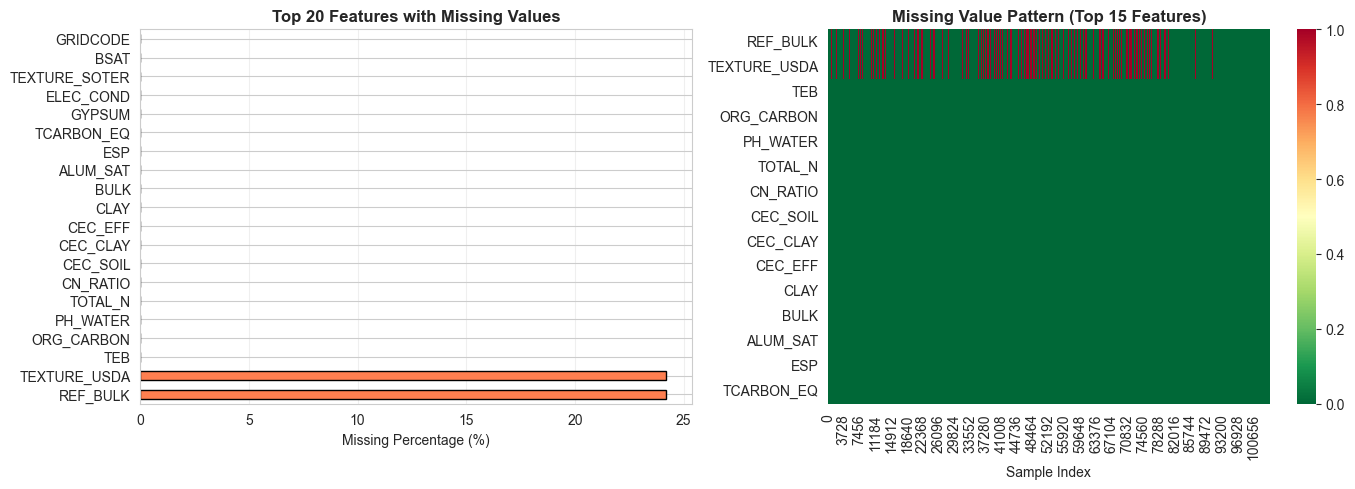

In [5]:


## 3. Missing Value Analysis

def analyze_missing_values(df):
    """
    Analyze and visualize missing values in the dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset to analyze
    """
    
    print("="*70)
    print("MISSING VALUE ANALYSIS")
    print("="*70)
    
    # Calculate missing percentages
    missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
    missing_pct = missing_pct[missing_pct > 0]
    
    if len(missing_pct) == 0:
        print(" No missing values found!")
        print("="*70)
        return
    
    print(f"\nFeatures with missing values: {len(missing_pct)}")
    print("\nMissing Value Summary:")
    print(missing_pct.to_frame(name='Missing %'))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot
    missing_pct.head(20).plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
    axes[0].set_xlabel('Missing Percentage (%)')
    axes[0].set_title('Top 20 Features with Missing Values', fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Heatmap of missing patterns
    missing_matrix = df[missing_pct.index[:15]].isna()
    sns.heatmap(missing_matrix.T, cbar=True, cmap='RdYlGn_r', ax=axes[1])
    axes[1].set_title('Missing Value Pattern (Top 15 Features)', fontweight='bold')
    axes[1].set_xlabel('Sample Index')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)

# Analyze missing values
analyze_missing_values(df)


## 4. Feature Encoding

In [6]:


# Encoding categorical variables for machine learning.
def encode_categorical_features(df):
    """
    Encode categorical features using Label Encoding.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset with categorical features
    
    Returns:
    --------
    df : DataFrame
        Dataset with encoded features
    encoders : dict
        Dictionary of encoders for each feature
    """
    
    print("="*70)
    print("FEATURE ENCODING")
    print("="*70)
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    
    
    print(f"Categorical features found: {len(categorical_cols)}")
    
    encoders = {}
    
    for col in categorical_cols:
        print(f"\nEncoding: {col}")
        print(f"  Unique values: {df[col].nunique()}")
        
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
        
        # Show mapping
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"  Mapping: {mapping}")
        
        print(f"   Encoded successfully")
    
    print("\n All categorical features encoded")
    print("="*70)
    
    return df, encoders

# Encode categorical features
df, encoders = encode_categorical_features(df)


FEATURE ENCODING
Categorical features found: 1

Encoding: TEXTURE_SOTER
  Unique values: 4
  Mapping: {'-': 0, 'C': 1, 'F': 2, 'M': 3, 'nan': 4}
   Encoded successfully

 All categorical features encoded


## 5. Missing Value Imputation

In [7]:



# Using KNN Imputation to handle missing values intelligently.
def impute_missing_values(df, n_neighbors=5):
    """
    Impute missing values using KNN Imputation.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset with missing values
    n_neighbors : int
        Number of neighbors for KNN imputation
    
    Returns:
    --------
    df : DataFrame
        Dataset with imputed values
    """
    
    print("="*70)
    print("MISSING VALUE IMPUTATION")
    print("="*70)
    
    # Identify columns with missing values
    missing_cols = df.columns[df.isnull().any()].tolist()
    
    if len(missing_cols) == 0:
        print(" No missing values to impute")
        print("="*70)
        return df
    
    print(f"Features with missing values: {len(missing_cols)}")
    print(f"Using KNN Imputation (k={n_neighbors})")
    
    # Store original shape
    original_shape = df.shape
    
    # Separate coordinates for spatial context
    coords_cols = ['latitude', 'longitude'] if all(c in df.columns for c in ['latitude', 'longitude']) else []
    
    if coords_cols:
        print(f"Using spatial coordinates: {coords_cols}")
        impute_cols = missing_cols + coords_cols
        
        # KNN Imputation
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        df[missing_cols] = knn_imputer.fit_transform(df[impute_cols])[:, :-len(coords_cols)]
    else:
        # Impute without spatial context
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        df[missing_cols] = knn_imputer.fit_transform(df[missing_cols])
    
    # Verify imputation
    remaining_missing = df[missing_cols].isnull().sum().sum()
    
    print(f"\n Imputation complete")
    print(f"Shape preserved: {df.shape == original_shape}")
    print(f"Remaining missing values: {remaining_missing}")
    
    print("="*70)
    
    return df

# Impute missing values
df = impute_missing_values(df, n_neighbors=5)

# Verify no missing values remain
print(f"\n Missing values after imputation:")
print(df.isnull().sum().sum())

MISSING VALUE IMPUTATION
Features with missing values: 22
Using KNN Imputation (k=5)
Using spatial coordinates: ['latitude', 'longitude']

 Imputation complete
Shape preserved: True
Remaining missing values: 0

 Missing values after imputation:
0


## 6. Outlier Analysis

In [8]:

# Detecting outliers in numerical features (optional treatment).

def analyze_outliers(df, target_col='fire'):
    """
    Analyze outliers using IQR method.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset to analyze
    target_col : str
        Target column to exclude from analysis
    """
    
    print("="*70)
    print("OUTLIER ANALYSIS")
    print("="*70)
    
    # Get numerical columns (excluding target)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    
    # Exclude coordinate columns
    coord_cols = ['latitude', 'longitude']
    num_cols = [c for c in num_cols if c not in coord_cols]
    
    print(f"Analyzing {len(num_cols)} numerical features\n")
    
    outlier_summary = []
    
    for col in num_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_pct = (outliers / len(df)) * 100
        
        if outliers > 0:
            outlier_summary.append({
                'Feature': col,
                'Q1': f"{q1:.2f}",
                'Q3': f"{q3:.2f}",
                'IQR': f"{iqr:.2f}",
                'Lower': f"{lower:.2f}",
                'Upper': f"{upper:.2f}",
                'Outliers': outliers,
                'Outlier %': f"{outlier_pct:.2f}%"
            })
    
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary).sort_values('Outliers', ascending=False)
        print("Features with Outliers (Top 20):")
        print(outlier_df.head(20).to_string(index=False))
    else:
        print(" No outliers detected")
    
    print("\nℹ  Note: Outliers are detected but not removed.")
    print("   Tree-based models are robust to outliers.")
    print("="*70)

# Analyze outliers
analyze_outliers(df)

OUTLIER ANALYSIS
Analyzing 36 numerical features

Features with Outliers (Top 20):
     Feature     Q1     Q3    IQR   Lower   Upper  Outliers Outlier %
    ALUM_SAT  -1.50   0.00   1.50   -3.75    2.25     20779    19.91%
  ORG_CARBON  -1.14   0.67   1.81   -3.86    3.38     19599    18.78%
    CN_RATIO   5.00  10.33   5.33   -3.00   18.33     19583    18.76%
 prec_winter   0.85   4.17   3.32   -4.13    9.14     17193    16.47%
         ESP   0.00   3.00   3.00   -4.50    7.50     15418    14.77%
    GRIDCODE 200.00 201.00   1.00  198.50  202.50     14227    13.63%
 prec_spring   0.98   5.50   4.52   -5.81   12.29     13668    13.10%
   ELEC_COND  -1.00   1.25   2.25   -4.38    4.62     13548    12.98%
   prec_fall   1.58   8.60   7.02   -8.94   19.13     11980    11.48%
TEXTURE_USDA   9.00  11.00   2.00    6.00   14.00      7655     7.33%
      GYPSUM  -1.35   2.77   4.12   -7.52    8.94      7529     7.21%
 tmax_spring  29.67  34.67   5.00   22.17   42.17      7157     6.86%
   tmax

## 7. Correlation Analysis

CORRELATION ANALYSIS
Analyzing correlations for 38 features
Correlation threshold: 0.9

 Highly correlated features (>0.9):
  • tmax_spring ↔ tmax_winter: 0.957
  • tmax_fall ↔ tmax_winter: 0.915
  • tmax_fall ↔ tmax_spring: 0.954
  • tmin_spring ↔ tmax_winter: 0.943
  • tmin_spring ↔ tmax_spring: 0.961
  • tmin_spring ↔ tmax_fall: 0.919
  • tmin_summer ↔ tmax_summer: 0.951
  • tmin_fall ↔ tmax_fall: 0.947
  • tmin_fall ↔ tmin_spring: 0.908
  • prec_fall ↔ prec_spring: 0.934
  • SAND ↔ COARSE: 0.920
  • CLAY ↔ SILT: 0.947
  • BULK ↔ COARSE: 0.905
  • BULK ↔ SAND: 0.944
  • BULK ↔ SILT: 0.942
  • BULK ↔ CLAY: 0.900
  • ORG_CARBON ↔ SILT: 0.949
  • ORG_CARBON ↔ CLAY: 0.929
  • ORG_CARBON ↔ BULK: 0.987
  • PH_WATER ↔ COARSE: 0.905
  • PH_WATER ↔ SAND: 0.950
  • PH_WATER ↔ SILT: 0.954
  • PH_WATER ↔ CLAY: 0.901
  • PH_WATER ↔ BULK: 0.994
  • PH_WATER ↔ ORG_CARBON: 0.972
  • TOTAL_N ↔ SAND: 0.915
  • TOTAL_N ↔ SILT: 0.954
  • TOTAL_N ↔ CLAY: 0.925
  • TOTAL_N ↔ BULK: 0.995
  • TOTAL_N ↔ ORG

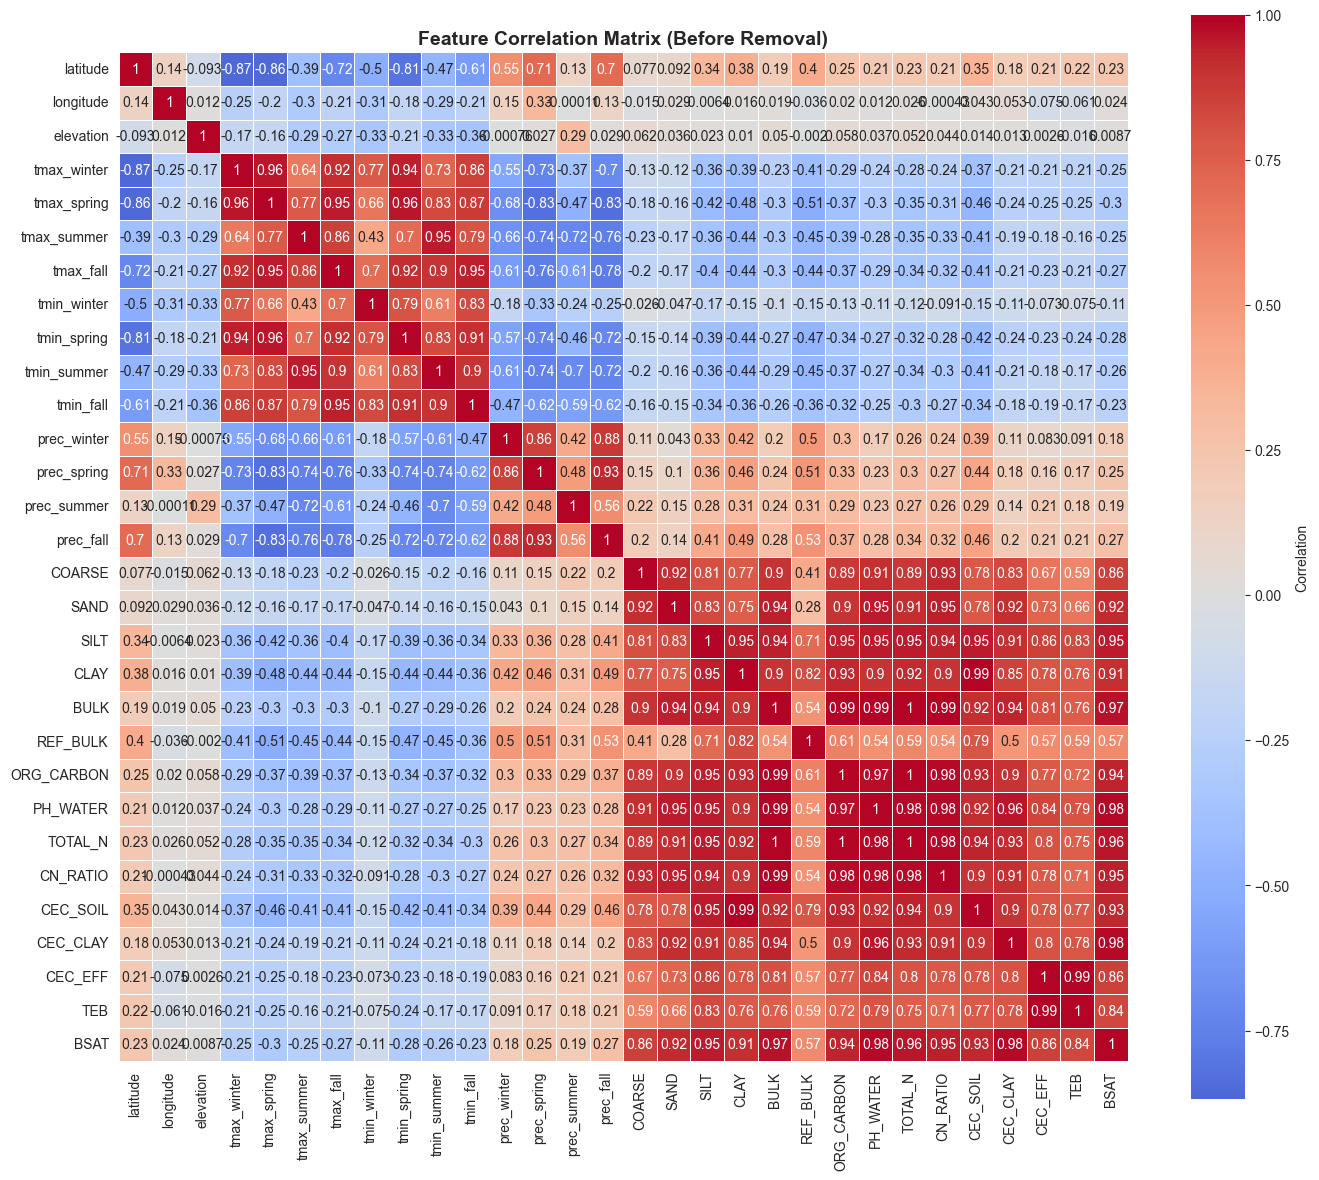

In [9]:
# Analyzing feature correlations and removing highly correlated features.
def analyze_correlations(df, target_col='fire', threshold=0.90):
    """
    Analyze correlations and identify highly correlated features.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset to analyze
    target_col : str
        Target column
    threshold : float
        Correlation threshold for feature removal
    
    Returns:
    --------
    to_drop : list
        List of features to drop
    """
    
    print("="*70)
    print("CORRELATION ANALYSIS")
    print("="*70)
    
    # Get numerical columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove target from correlation analysis
    if target_col in num_cols:
        num_cols.remove(target_col)
    
    print(f"Analyzing correlations for {len(num_cols)} features")
    print(f"Correlation threshold: {threshold}")
    
    # Compute correlation matrix
    corr_matrix = df[num_cols].corr().abs()
    
    # Upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find highly correlated features
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"\n Highly correlated features (>{threshold}):")
    if to_drop:
        for col in to_drop:
            correlated_with = upper[col][upper[col] > threshold].index.tolist()
            for cor_col in correlated_with:
                corr_val = corr_matrix.loc[col, cor_col]
                print(f"  • {col} ↔ {cor_col}: {corr_val:.3f}")
        
        print(f"\n Features to remove: {len(to_drop)}")
        print(to_drop)
    else:
        print("   No highly correlated features found")
    
    # Visualize correlation matrix (before removal)
    print("\nGenerating correlation heatmap...")
    
    # Sample features if too many
    if len(num_cols) > 30:
        print(f"  Sampling 30 features for visualization")
        viz_cols = num_cols[:30]
    else:
        viz_cols = num_cols
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(df[viz_cols].corr(), annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
    plt.title('Feature Correlation Matrix (Before Removal)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    
    return to_drop

# Analyze correlations
to_drop = analyze_correlations(df, threshold=0.90)


REMOVING HIGHLY CORRELATED FEATURES
Original shape: (104372, 39)
Reduced shape: (104372, 18)
Features removed: 21
Features retained: 18

 Highly correlated features removed


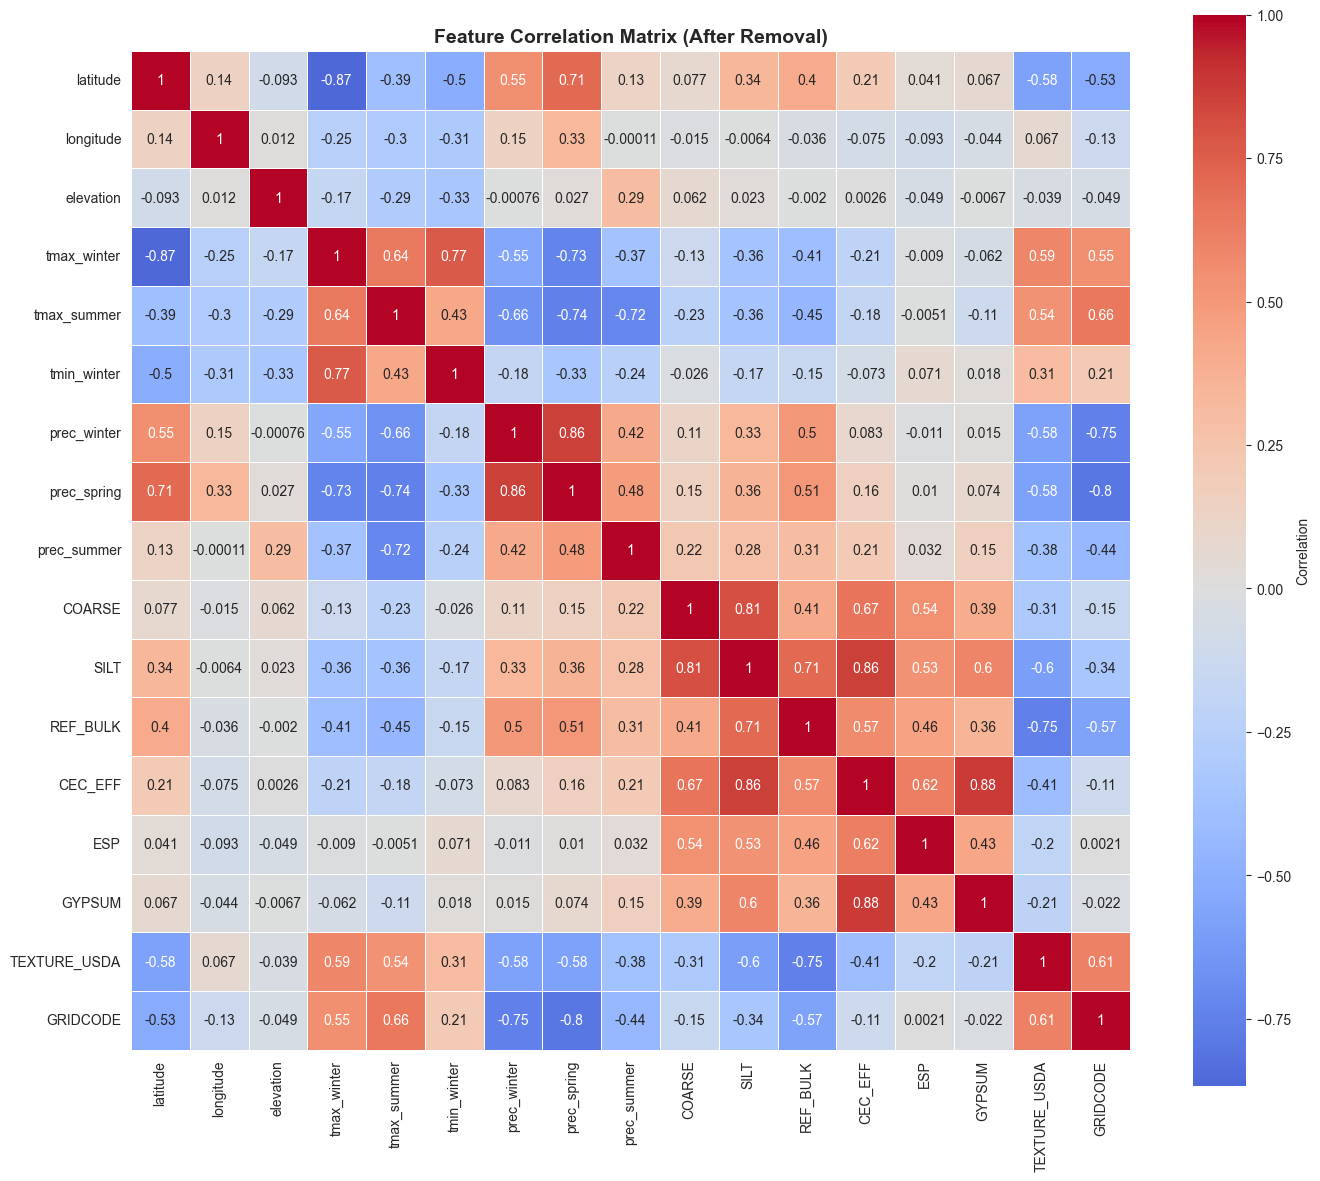

In [10]:

## 7.1 Remove Highly Correlated Features

def remove_correlated_features(df, to_drop):
    """
    Remove highly correlated features from dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Dataset
    to_drop : list
        Features to remove
    
    Returns:
    --------
    df_reduced : DataFrame
        Dataset with reduced features
    """
    
    print("="*70)
    print("REMOVING HIGHLY CORRELATED FEATURES")
    print("="*70)
    
    original_shape = df.shape
    df_reduced = df.drop(columns=to_drop)
    
    print(f"Original shape: {original_shape}")
    print(f"Reduced shape: {df_reduced.shape}")
    print(f"Features removed: {len(to_drop)}")
    print(f"Features retained: {df_reduced.shape[1]}")
    
    print("\n Highly correlated features removed")
    print("="*70)
    
    return df_reduced

# Remove correlated features
df = remove_correlated_features(df, to_drop)

# Visualize correlation matrix after removal
def visualize_reduced_correlations(df, target_col='fire'):
    """Visualize correlation matrix after feature removal."""
    
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    
    # Sample if too many
    if len(num_cols) > 30:
        viz_cols = num_cols[:30]
    else:
        viz_cols = num_cols
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(df[viz_cols].corr(), annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
    plt.title('Feature Correlation Matrix (After Removal)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_reduced_correlations(df)

## 8. Final Data Preparation

In [11]:

def prepare_final_dataset(df):
    """
    Prepare final clean dataset for modeling.
    
    Parameters:
    -----------
    df : DataFrame
        Preprocessed dataset
    
    Returns:
    --------
    df : DataFrame
        Final dataset
    """
    
    print("="*70)
    print("FINAL DATA PREPARATION")
    print("="*70)
    
    print(f"Final dataset shape: {df.shape}")
    print(f"\nFeature types:")
    print(df.dtypes.value_counts())
    
    print(f"\nTarget distribution:")
    print(df['fire'].value_counts())
    
    print(f"\nMissing values: {df.isnull().sum().sum()}")
    
    # Summary statistics
    print("\nNumerical feature summary:")
    print(df.describe().T[['mean', 'std', 'min', 'max']])
    
    print("\n Dataset ready for modeling")
    print("="*70)
    
    return df

# Prepare final dataset
df = prepare_final_dataset(df)


FINAL DATA PREPARATION
Final dataset shape: (104372, 18)

Feature types:
float64    16
int64       2
Name: count, dtype: int64

Target distribution:
fire
0    90156
1    14216
Name: count, dtype: int64

Missing values: 0

Numerical feature summary:
                    mean         std           min          max
latitude       29.049579    4.330009     19.603230    37.323460
longitude       3.527196    4.413657     -8.118050    11.110350
fire            0.136205    0.343008      0.000000     1.000000
elevation     501.431457  553.953207 -32768.000000  2475.000000
tmax_winter    20.921849    3.633717      6.250000    28.666667
tmax_summer    40.996738    3.685791     27.666667    46.666667
tmin_winter     6.680054    2.061566     -1.333333    11.833333
prec_winter     7.991954   19.049141      0.000000   207.466665
prec_spring     5.381005    7.825661      0.000000    58.950002
prec_summer     2.332153    2.574665      0.000000    14.041667
COARSE          7.986220    7.428146     -9.000

## 9. Save Cleaned Dataset

In [18]:

def save_cleaned_data(df, output_path):
    """
    Save cleaned dataset to CSV.
    
    Parameters:
    -----------
    df : DataFrame
        Cleaned dataset
    output_path : str
        Output file path
    """
    
    print("="*70)
    print("SAVING CLEANED DATASET")
    print("="*70)
    
    df.to_csv(output_path, index=False)
    
    file_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
    
    print(f"✅ Dataset saved to: {output_path}")
    print(f"File size: {file_size:.2f} MB")
    print(f"Shape: {df.shape}")
    print("="*70)

import os
os.makedirs("../data/processed/Fire", exist_ok=True)
save_cleaned_data(df, "../data/processed/Fire/final.csv")


SAVING CLEANED DATASET
✅ Dataset saved to: ../data/processed/Fire/final.csv
File size: 20.48 MB
Shape: (104372, 18)
